## Advanced Validation Lecture

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Predicting Survival on the Titanic using Random Forest

Random Forest classifier to predict survival on the titanic.   

Independent variables to predict the dependent variable survived.  There are many other variables in the dataset that you could and should use, that will be your assignment for the week.   (More on that later)

###Data Prep
First, I will start with some data prep to get my data ready to be used in a model

In [27]:
data = pd.read_csv("../data/train.csv")

In [28]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
X = pd.DataFrame()
X['Parch'] = data['Parch']
X['Pclass'] = data['Pclass']
X['SibSp'] = data['SibSp']
X['age'] = data['Age']
X['sex'] = data['Sex']
X['survived'] = data['Survived']
X['name'] = data['Name']
X['Fare'] = data['Fare']

In [30]:
median_ages = np.zeros((2,3))
for i in range(0,2):
        for j in range(0,3):
            median_ages[i,j] = X[(X.sex == i) & (X.Pclass == j+1)].age.dropna().median()
X['AgeFill']=X.age
X['penalty']=0
# fill in null female ages
for j in range(0,3):
    X.loc[(X.age.isnull())&(X.sex == 0)&(X.Pclass == j+1)&(X['name'].str.contains('Mrs. ')),'AgeFill']=median_ages[0,j]
    X.loc[(X.age.isnull())&(X.sex == 0)&(X.Pclass == j+1)&(X['name'].str.contains('Ms. ')),'AgeFill']=median_ages[0,j]
    X.loc[(X.age.isnull())&(X.sex == 0)&(X.Pclass == j+1)&(X['name'].str.contains('Miss. '))&(X.Parch ==0),'AgeFill']=median_ages[0,j]
    X.loc[(X.age.isnull())&(X.sex == 0)&(X.Pclass == j+1)&(X['name'].str.contains('Miss. '))&(X.Parch >0),'AgeFill']=8
    X.loc[(X.age.isnull())&(X.sex == 0)&(X.Pclass == j+1)&(X['name'].str.contains('Miss. '))&(X.Parch >0),'penalty']=1

# fill in null male ages
for j in range(0,3):
    X.loc[(X.age.isnull())&(X.sex == 1)&(X.Pclass == j+1)&(X['name'].str.contains('Mr. ')),'AgeFill']=median_ages[1,j]
    X.loc[(X.age.isnull())&(X.sex == 1)&(X.Pclass == j+1)&(X['name'].str.contains('Mr. ')),'penalty']=1
    X.loc[(X.age.isnull())&(X.sex == 1)&(X.Pclass == j+1)&(X['name'].str.contains('Master. ')),'AgeFill']=8
    X.loc[(X.age.isnull())&(X.sex == 1)&(X.Pclass == j+1)&(X['name'].str.contains('Dr. ')),'AgeFill']=median_ages[1,j]

In [31]:
X['AgeNorm'] = X.AgeFill
X.AgeNorm = (X.AgeNorm - X.AgeFill.mean()) / X.AgeFill.std()

In [32]:
# combine parent and sibling data into FamilySize
X['FamilySize']=X.SibSp+X.Parch

In [33]:
# Group ages to simplify machine learning algorithms.  0:0-5, 1:6-10, 2:11-15, 3:16-59, 4:>60
X['AgeGroup']=0
X.loc[(X.AgeFill<6),'AgeGroup']=0
X.loc[(X.AgeFill>=6) & (X.AgeFill <11),'AgeGroup']=1
X.loc[(X.AgeFill>=11) & (X.AgeFill <16),'AgeGroup']=2
X.loc[(X.AgeFill>=16) & (X.AgeFill <60),'AgeGroup']=3
X.loc[(X.AgeFill>=60),'AgeGroup']=4

In [34]:
# fill in estimates for the missing fares, by class, for training data
median_fares = np.zeros(3)
for i in range(0,3):
    median_fares[i] = X[(X.Pclass == i+1)].Fare.dropna().median()

X['FareFill']=X.Fare
for i in range(0,3):
    X.loc[(X.Fare.isnull())&(X.Pclass == i+1),'FareFill']=median_fares[i]

In [35]:
X['FareNorm'] = X.FareFill
X.FareNorm = (X.FareNorm - X.FareFill.mean()) / X.FareFill.std()

In [36]:
X = X.dropna(axis=0)

In [37]:
#survived will be my dependent variable, y.   I'll assign it to y and remove it from X
y = X['survived']
X = X.drop(['survived'], axis=1)

In [38]:
pd.get_dummies(X.sex)

,female,male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,1.0,0.0
9,1.0,0.0
10,1.0,0.0


In [39]:
#IMPORTANT! get_dummies returns an indicator variable for each category.
#Refering back to my talk on encoding variables, it's important to drop one category
#Otherwise you'll have two perfectly colinear variables.   

#Here, since I only have two variables it's easy, I'll just take one, and reassign it to sex
#so now Sex becomes female = 1, male = 0
X['sex'] = pd.get_dummies(X.sex)['female']

In [40]:
del X['name']
del X['AgeFill']
del X['age']
del X['Fare']
del X['FareFill']

In [41]:
#remember to scale our features, as with linear regression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [42]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
model = RandomForestClassifier(n_jobs=1)
model.fit(X_train, y_train)
print ("R^2:", model.score(X_test, y_test).round(2))

R^2: 0.78


### Grid Search!

In [44]:
### Grid Search
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3, 5, 7]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)
                              

In [45]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500], 'min_samples_split': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [46]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
best_rfc = estimator.best_estimator_

### Accuracy



In [48]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print ("Accuracy: ", accuracy)

Accuracy:  0.804195804196


In [49]:
y_hat = best_rfc.predict(X_test)

In [50]:
y_hat

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1])

In [51]:
y_test

149    0
407    1
53     1
369    1
818    0
549    1
85     1
774    1
100    0
816    0
781    1
123    1
690    1
108    0
258    1
529    0
296    0
329    1
886    0
513    1
71     0
259    1
852    0
737    1
225    0
163    0
282    0
93     0
111    0
471    0
      ..
449    1
433    0
79     1
206    0
39     1
90     0
668    0
307    1
59     0
353    0
91     0
498    0
810    0
836    0
389    1
422    0
194    1
267    1
392    0
207    1
516    1
7      0
320    0
752    0
273    0
819    0
164    0
363    0
56     1
136    1
Name: survived, dtype: int64

In [52]:
correct = 0
total = y_test.shape[0]
for pred_val, truth_val in zip(y_hat, y_test):
    if pred_val == truth_val:
        correct +=1

print (correct / float(total))
        

0.8041958041958042


### Precision and Recall

In [53]:
print (classification_report(y_test, best_rfc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.83      0.85      0.84        87
          1       0.76      0.73      0.75        56

avg / total       0.80      0.80      0.80       143



Precision:   The model will correctly identify 96% of winners.   Conversely there is a 4% chance it will identify a non-winner as a winner.  (tp / tp+fp)

Recall:  Of the people the model identified as winners, 96% of them will actually be winners.  (tp / tp + fn)

In [54]:
print (confusion_matrix(y_test, best_rfc.predict(X_test)))

[[74 13]
 [15 41]]


**Precision:**  41 / 41 + 13 = .76

**Recall:**   41 / 41 + 15 = .73

### AUC

In [55]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print ("AUC Score: ", roc)

AUC Score:  0.824815270936


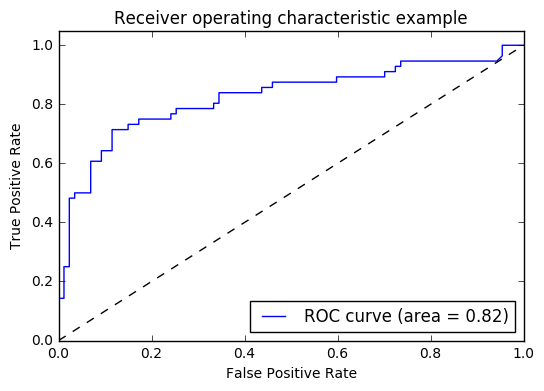

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### But!  

So far our entire strategy has been to fit a model as strongly as possible to our 20% holdout.   What if our 20% hold out doesn't contain the tricky cases, or certain edge cases?  What if our random 20% sample doesn't really reflect reality?

When we choose hyperparameters, we choose them to optimize the 20% holdout.   

Our model will overfit to the 20% holdout, and may not actually perform well in real life.




### Train, Test, Validation

What if instead, we split our data into three sets?   

Train = 60% for training

Validation = 20% for model tuning

Test = 20% for actual model testing.   Not used for parameter estimation.


**Pros:**  This keeps overfitting to our test set under control.   

**Cons:** Our training data keeps getting smaller.   

Good method for very large N, but here we have a smaller N.


### K-Fold Cross Validation

1.  Split the data into K chunks
2.  Train K models, retain a chunk for testing and use the other K-1 chunks for training.
3.  The result is K scores, which can be combined into a single average score for the model

In [58]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, X, y, cv=10)

In [59]:
scores

array([ 0.70833333,  0.80555556,  0.76388889,  0.90277778,  0.87323944,
        0.8028169 ,  0.83098592,  0.74647887,  0.84507042,  0.87323944])

In [63]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print ("Score is %f +/-  %f" % (mean_score, ci))
print ('95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound))

Score is 0.815239 +/-  0.042058
95 percent probability that if this experiment were repeated over and over the average score would be between 0.773181 and 0.857296
